# Direct methods for solving linear systems

Recall the prototypal PDE problem introduce in the Lecture 08:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, 1)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, 1\}
$$

The physical interpretation of this problem is related to the modelling of an elastic string, which occupies at rest the space $[0,1]$ and is fixed at the two extremes. The unknown $u(x)$ represents the displacement of the string at the point $x$, and the right-hand side models a prescribed force $f(x)$ on the string.

For the numerical discretization of the problem, we consider a **Finite Difference (FD) Approximation**. Let $n$ be an integer, a consider a uniform subdivision of the interval $(0,1)$ using $n+1$ equispaced points, denoted by $\{x_i\}_{i=0}^n$ . Moreover, let $u_i$ be the FD approximation of $u(x_i)$, and similarly $f_i \approx f(x_i)$.

In order to formulate the discrete problem, we consider a FD approximation of the left-hand side, as follows:
$$
-u_{xx}(x_i) \approx \frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2}
$$
being $h = \frac{1}{n-1}$ the size of each subinterval $(x_i, x_{i+1})$.

The problem that we need to solve is
$$
u_i = 0 \qquad\qquad\qquad\qquad i=0,
$$
$$
\frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2} = f_i \qquad\qquad\qquad i=1, \ldots, n-1,\qquad\qquad\qquad(P)
$$
$$
u_i = 0 \qquad\qquad\qquad\qquad i=n.
$$

Then, let us collect al the unknowns $\{u_i\}_{i=0}^n$ in a vector $\mathbf{u}$. Then, (P) is a linear system
$$
A \mathbf{u} = \mathbf{f}.
$$

In this exercise we will show how to use direct methods to solve linear systems, and in particular we will discuss the **LU** and **Cholesky** decompositions that you have studied in Lecture 07.



First of all, let use define $n$ and $\{x_i\}_{i=0}^n$.

In [2]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

#slight inconsistency; in the explanation we have n+1 points, n intervals
#here we have n points, n-1 intervals
n = 33
h = 1./(n-1)

x = linspace(0,1,n)

Let us define the left-hand side matrix $A$.

In [3]:
a = -ones((n-1,)) # Offdiagonal entries
b = 2*ones((n,)) # Diagonal entries
#diag builds a matrix from a vector and the offset with which it appears
#-1 means "1 under the main diagonal"
A = (diag(a, -1) + diag(b, 0) + diag(a, 1))
A /= h**2

print(A)
print(linalg.cond(A))

[[ 2048. -1024.     0. ...     0.     0.     0.]
 [-1024.  2048. -1024. ...     0.     0.     0.]
 [    0. -1024.  2048. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ...  2048. -1024.     0.]
 [    0.     0.     0. ... -1024.  2048. -1024.]
 [    0.     0.     0. ...     0. -1024.  2048.]]
467.8426288390642


Moreover, let us choose 
$$
f(x) = x (1-x)
$$
so that the solution $u(x)$ can be computed analytically as
$$
u(x) = u_{\mathrm{ex}}(x) = \frac{x^4}{12} - \frac{x^3}{6} +\frac{x}{12}
$$

The right hand side $\mathbf{f}$ then is easily assembled as:

In [4]:
f = x*(1.-x)

We still need to impose the boundary conditions at $x=0$ and $x=1$, which read
$$
u_i = 0 \qquad\qquad\qquad\qquad i=0,
$$
and
$$
u_i = 0 \qquad\qquad\qquad\qquad i=n,
$$

These conditions are associated with the first (last, respectively) row of the linear system.

Then we can solve the linear system and compare the FD approximation of $u$ to the exact solution $u_{\mathrm{ex}}$.

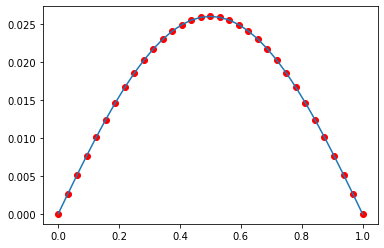

In [6]:
#change upper left boundary of the matrix A
A[0,:] = 0
A[:,0] = 0
A[0,0] = 1
#and the rhs
f[0] = 0

#change lower right boundary of the matrix A
A[-1,:] = 0
A[:,-1] = 0
A[-1,-1] = 1
#and the rhs
f[-1] = 0

# Solve the linear system using numpy
A1 = A.copy()
u = linalg.solve(A1, f)
u_ex = (x**4)/12. - (x**3)/6. + x/12.

# Plot the FD and exact solution
_ = plot(x,u,'ro')
_ = plot(x,u_ex)

## LU decomposition

We want to implement our linear solver using an **LU decomposition** (without pivoting)
$$
A = LU
$$

LU decomposition can be computed as in the following function.

In [7]:
def LU(A):
    A = A.copy()
    N = len(A)
    #leave out the last row
    for k in range(N-1):
        if (abs(A[k, k]) < 1e-15):
            raise RuntimeError("Null pivot")
        
        #mult the rest of the columns by the diag element
        A[k+1:N, k] /= A[k,k]
        for j in range(k+1, N):
            #subtract current rest of the column (modulated by its first element) from rest of the columns
            A[k+1:N, j] -= A[k+1:N, k] * A[k, j]
    #extract triangulat lower
    L = tril(A)
    for i in range(N):
        L[i, i] = 1.0
    #extract triangulat upper
    U = triu(A)
    return L, U

L, U = LU(A)

Once $L$ and $U$ have been computed, the system
$$
A\mathbf{u}=\mathbf{f}
$$
can be solved in **two steps**: first solve
$$
L\mathbf{w}=\mathbf{f},
$$
where $L$ is a **lower triangular matrix**, and then solve
$$
U\mathbf{u}=\mathbf{w}
$$
where $U$ is an **upper triangular matrix**.

These two systems can be easily solved by forward (backward, respectively) substitution.

In [8]:
def L_solve(L,rhs):
    x = zeros_like(rhs)
    N = len(L)
        
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i, 0:i], x[0:i]))/L[i,i]
    
    return x


In [17]:
def U_solve(U, rhs):
    x = zeros_like(rhs)
    N = len(U)
        
    x[-1] = rhs[-1]/U[-1,-1]
    for i in range(N-2, -1, -1):
        x[i] = (rhs[i] - dot(U[i, i+1:], x[i+1:])) / U[i, i]
    
    return x

Now let's solve the system 
$$
A\mathbf{u}=\mathbf{f}
$$

and compare the solution with respect to the exact solution.

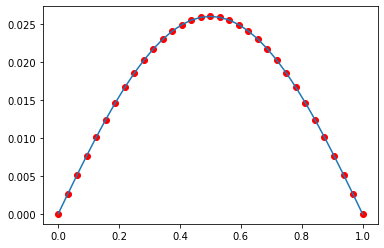

In [32]:
k = 1
f = k*x*(1.-x)
u_ex = k*(x**4)/12. - k*(x**3)/6. + k*x/12.

w = L_solve(L,f)
u = U_solve(U,w)

_ = plot(x,u,'ro')
_ = plot(x,u_ex)

### try to compute the solution $u(x)$ with different forcing terms and compare with the exact solution **without recomputing the LU decomposition**

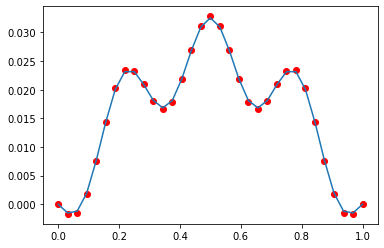

In [45]:
k = pi
k2 = -7*pi
f = x*(1.-x) + k*sin(k2*x)
u_ex = (x**4)/12. - (x**3)/6. + x/12. + k*sin(k2*x)/k2**2

w = L_solve(L, f)
u = U_solve(U, w)

_ = plot(x,u,'ro')
_ = plot(x,u_ex)

## Cholesky decomposition
For symmetric and positive define matrices, the Cholesky decomposition may be preferred since it reduces the number of flops for computing the LU decomposition by a factor of 2.

The Cholesky decomposotion seeks an upper triangular matrix $H$ (with all positive elements on the diagonal) such that
$$
A = H^T H
$$

An implementation of the Cholesky decomposition is provided in the following function. We can use it to solve the linear system by forward and backward substitution.

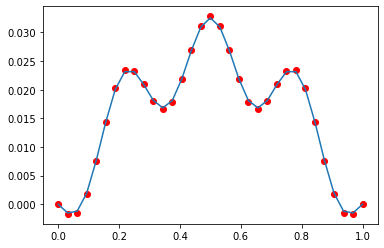

In [46]:
def cholesky(A):
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = sqrt(A[-1,-1])
    L=tril(A)
    return L, L.transpose()


HT, H = cholesky(A)
y = L_solve(HT,f)
u = U_solve(H,y)


_ = plot(x,u,'ro')
_ = plot(x,u_ex)